In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers

# Portfolio Allocation



### Country bucket
Use ETFs: EWH, EWA, EWJ. Allocate according to mu + sigma, MPT, risk tolerance 5. If there is more than a 5% change in allocation for any country, then readjust. 

- China: EWH
- Australia: EWA
- Japan: EWJ

### Sector bucket 
Use ETFs for each specific industry in the foreign exchange. Again, allocate according to mu + sigma, MPT, risk tolerance 10. If there is more than a 5% change in allocation for any sector, then readjust.

- Global Healthcare: IXJ
- Global Financials: IXG
- Global Materials: MXI
- Global Utilities: JXI
- Global Energy: IXC
- Global Industrials: EXI
- Global Information Technology: IXN
- Global Consumer Discretionary: RXI

### Within sectors
Allocate according to return, hit ratio, and volatility. Directly proportional to return and hit ratio, inversely proportional to volatility. If there is more than a 10% change in allocation for any stock, then readjust. 

In [24]:
def data_processing(name):
    path = f'{name}.csv'
    df = pd.read_csv(path, index_col = 0)
    df = df[['date', 'close']]
    return df.rename(columns = {'close' : f'{name}_close'})

In [64]:
def mpo(df):
    n = len(df)
    returns = np.asmatrix(df)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b, options={'show_progress': False})['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    opt_wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b, options={'show_progress': False})['x']
    wts = [solvers.qp(opt.matrix(mu * S), -pbar, G, h, A, b, options={'show_progress': False})['x']
           for mu in mus]
    cum_wts = []
    for wt in wts:
        cum_wts.append(np.asarray(wt))
    return np.asarray(opt_wt), np.asarray(cum_wts), returns, risks

## Country allocation

In [58]:
china_df = data_processing('China')
japan_df = data_processing('Japan')
aus_df = data_processing('Australia')

df = pd.merge(china_df, japan_df, on = 'date')
df = pd.merge(df, aus_df, on = 'date')
df.head()

,date,China_close,Japan_close,Australia_close
0,2015-04-23,23.72,53.04,23.40
1,2015-04-24,23.92,53.24,23.93
2,2015-04-27,23.98,53.12,24.05
3,2015-04-28,24.02,53.28,24.39
4,2015-04-29,23.91,52.80,23.81


In [65]:
"""
Return appropriate capital allocation per country on given date.
"""

def country_alloc(date, ret_threshold = -1, risk_threshold = 1):
    
    china_df = data_processing('China')
    japan_df = data_processing('Japan')
    aus_df = data_processing('Australia')

    df = pd.merge(china_df, japan_df, on = 'date')
    df = pd.merge(df, aus_df, on = 'date')
    
    ind = 0
    # Lookback 100 days
    for i in df.index:
        if df['date'].loc[i] > date:
            ind = i
            break
    
    df = df.iloc[ind - 100 : ind]
    df = df.drop(columns = 'date')
    
    opt_wt, wts, returns, risks = mpo(df.pct_change().dropna().T)
    filtered_wts = [wts[i] for i in range(len(returns)) if returns[i] >= ret_threshold and risks[i] <= risk_threshold]
    filtered_ret = [returns[i] for i in range(len(returns)) if returns[i] >= ret_threshold and risks[i] <= risk_threshold]
    filtered_risk = [risks[i] for i in range(len(returns)) if returns[i] >= ret_threshold and risks[i] <= risk_threshold]
    plt.ylabel('mean')
    plt.xlabel('std')
    plt.plot(risks, returns, 'b-o')
    print(opt_wt)
    return filtered_wts, filtered_ret, filtered_risk

     China_close  Japan_close  Australia_close
76         21.91        51.60            19.94
77         21.29        51.28            19.95
78         21.30        51.68            19.89
79         21.47        51.68            19.86
80         21.30        51.80            19.93
..           ...          ...              ...
171        20.03        48.48            18.73
172        19.83        48.52            18.69
173        19.97        49.24            19.20
174        19.91        48.96            19.16
175        19.82        48.48            18.96

[100 rows x 3 columns]
[[6.86813270e-07]
 [2.75261187e-05]
 [9.99971787e-01]]


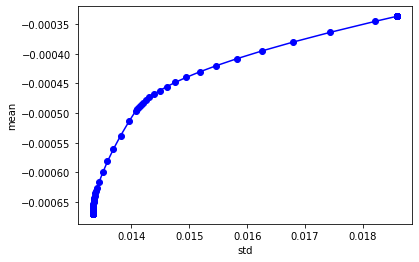

In [66]:
wts, ret, risk = country_alloc("2016-01-01")

In [57]:
print(wts, ret, risk)

[array([[1.50316892e-06],
       [9.99996329e-01],
       [2.16744836e-06]]), array([[1.50335529e-06],
       [9.99996335e-01],
       [2.16204738e-06]]), array([[1.50356442e-06],
       [9.99996340e-01],
       [2.15598962e-06]]), array([[1.50379909e-06],
       [9.99996347e-01],
       [2.14919550e-06]]), array([[1.50406244e-06],
       [9.99996354e-01],
       [2.14157592e-06]]), array([[1.50435796e-06],
       [9.99996363e-01],
       [2.13303106e-06]]), array([[1.50468961e-06],
       [9.99996372e-01],
       [2.12344918e-06]]), array([[1.50506180e-06],
       [9.99996382e-01],
       [2.11270521e-06]]), array([[1.50547950e-06],
       [9.99996394e-01],
       [2.10065918e-06]]), array([[1.50594828e-06],
       [9.99996407e-01],
       [2.08715455e-06]]), array([[1.50647442e-06],
       [9.99996422e-01],
       [2.07201624e-06]]), array([[1.50706495e-06],
       [9.99996438e-01],
       [2.05504859e-06]]), array([[1.50772778e-06],
       [9.99996456e-01],
       [2.03603304e-06]])

In [29]:
df = pd.DataFrame(np.random.normal(0.4,0.1,size=(15, 3)), columns=list('ABC'))
wts, returns, risks = mpo(df.pct_change().dropna().T)

     pcost       dcost       gap    pres   dres
 0: -4.8801e-02 -1.0642e+00  1e+00  2e-16  2e+00
 1: -4.9047e-02 -7.4108e-02  3e-02  1e-16  6e-02
 2: -5.7663e-02 -6.1618e-02  4e-03  1e-16  8e-18
 3: -6.0091e-02 -6.0373e-02  3e-04  3e-16  1e-17
 4: -6.0333e-02 -6.0338e-02  6e-06  1e-16  2e-18
 5: -6.0338e-02 -6.0338e-02  6e-08  8e-20  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.8658e-02 -1.0640e+00  1e+00  2e-16  2e+00
 1: -4.8900e-02 -7.3839e-02  2e-02  1e-16  6e-02
 2: -5.7032e-02 -6.0973e-02  4e-03  1e-16  4e-18
 3: -5.9327e-02 -5.9660e-02  3e-04  1e-16  5e-18
 4: -5.9594e-02 -5.9607e-02  1e-05  1e-16  1e-17
 5: -5.9606e-02 -5.9606e-02  1e-07  5e-20  7e-18
 6: -5.9606e-02 -5.9606e-02  1e-09  2e-16  6e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.8497e-02 -1.0637e+00  1e+00  0e+00  2e+00
 1: -4.8735e-02 -7.3538e-02  2e-02  6e-17  6e-02
 2: -5.6371e-02 -6.0273e-02  4e-03  1e-16  1e-17
 3: -5.8504e-02 -5.8875e

 4: -3.5620e-02 -3.5620e-02  8e-08  2e-16  1e-07
 5: -3.5620e-02 -3.5620e-02  8e-10  0e+00  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.3620e-02 -1.0383e+00  1e+00  2e-16  2e+00
 1: -3.3640e-02 -4.7790e-02  1e-02  2e-16  3e-02
 2: -3.3745e-02 -3.4159e-02  4e-04  1e-16  8e-04
 3: -3.3748e-02 -3.3753e-02  5e-06  1e-16  8e-06
 4: -3.3748e-02 -3.3748e-02  5e-08  6e-17  8e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.1656e-02 -1.0351e+00  1e+00  2e-16  2e+00
 1: -3.1667e-02 -4.4650e-02  1e-02  2e-16  3e-02
 2: -3.1708e-02 -3.1971e-02  3e-04  1e-16  6e-04
 3: -3.1708e-02 -3.1711e-02  3e-06  1e-16  6e-06
 4: -3.1708e-02 -3.1708e-02  3e-08  0e+00  6e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.9458e-02 -1.0315e+00  1e+00  2e-16  2e+00
 1: -2.9463e-02 -4.1195e-02  1e-02  2e-16  3e-02
 2: -2.9474e-02 -2.9620e-02  1e-04  1e-16  3e-04
 3: -2.9474e-02 -2.9475e-02  1e-06  6e-17  3e-06


 4:  3.7031e-01  3.7031e-01  6e-08  8e-17  8e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.2516e-01 -6.5101e-01  1e+00  1e-16  2e+00
 1:  4.2190e-01  3.8134e-01  4e-02  6e-17  9e-02
 2:  4.2117e-01  4.2061e-01  6e-04  1e-16  9e-04
 3:  4.2117e-01  4.2116e-01  6e-06  2e-16  9e-06
 4:  4.2117e-01  4.2117e-01  6e-08  6e-17  9e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.8212e-01 -5.9699e-01  1e+00  2e-16  2e+00
 1:  4.7884e-01  4.3959e-01  4e-02  1e-16  9e-02
 2:  4.7823e-01  4.7772e-01  5e-04  8e-17  8e-04
 3:  4.7823e-01  4.7823e-01  5e-06  6e-17  8e-06
 4:  4.7823e-01  4.7823e-01  5e-08  2e-16  8e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.4602e-01 -5.3589e-01  1e+00  2e-16  2e+00
 1:  5.4276e-01  5.0498e-01  4e-02  1e-16  8e-02
 2:  5.4226e-01  5.4179e-01  5e-04  1e-16  8e-04
 3:  5.4226e-01  5.4225e-01  5e-06  2e-16  8e-06
 4:  5.4226e-01  5.4226e-01  5e-08  6e-17  8e-08


 3:  1.1699e+01  1.1699e+01  1e-06  6e-17  3e-06
 4:  1.1699e+01  1.1699e+01  1e-08  2e-16  3e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.3133e+01  1.2022e+01  1e+00  1e-16  3e+00
 1:  1.3133e+01  1.3121e+01  1e-02  2e-16  3e-02
 2:  1.3133e+01  1.3132e+01  1e-04  6e-17  3e-04
 3:  1.3133e+01  1.3133e+01  1e-06  6e-17  3e-06
 4:  1.3133e+01  1.3133e+01  1e-08  8e-17  3e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.4741e+01  1.3630e+01  1e+00  0e+00  3e+00
 1:  1.4741e+01  1.4729e+01  1e-02  6e-17  3e-02
 2:  1.4741e+01  1.4741e+01  1e-04  1e-16  3e-04
 3:  1.4741e+01  1.4741e+01  1e-06  6e-17  3e-06
 4:  1.4741e+01  1.4741e+01  1e-08  6e-17  3e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.6545e+01  1.5434e+01  1e+00  2e-16  3e+00
 1:  1.6545e+01  1.6534e+01  1e-02  0e+00  3e-02
 2:  1.6545e+01  1.6545e+01  1e-04  6e-17  3e-04
 3:  1.6545e+01  1.6545e+01  1e-06  8e-17  3e-06


 1: -3.5406e-02 -5.0640e-02  2e-02  0e+00  4e-02
 2: -3.5610e-02 -3.6198e-02  6e-04  8e-17  1e-03
 3: -3.5620e-02 -3.5629e-02  8e-06  1e-16  1e-05
 4: -3.5620e-02 -3.5620e-02  8e-08  2e-16  1e-07
 5: -3.5620e-02 -3.5620e-02  8e-10  0e+00  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.3620e-02 -1.0383e+00  1e+00  2e-16  2e+00
 1: -3.3640e-02 -4.7790e-02  1e-02  2e-16  3e-02
 2: -3.3745e-02 -3.4159e-02  4e-04  1e-16  8e-04
 3: -3.3748e-02 -3.3753e-02  5e-06  1e-16  8e-06
 4: -3.3748e-02 -3.3748e-02  5e-08  6e-17  8e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.1656e-02 -1.0351e+00  1e+00  2e-16  2e+00
 1: -3.1667e-02 -4.4650e-02  1e-02  2e-16  3e-02
 2: -3.1708e-02 -3.1971e-02  3e-04  1e-16  6e-04
 3: -3.1708e-02 -3.1711e-02  3e-06  1e-16  6e-06
 4: -3.1708e-02 -3.1708e-02  3e-08  0e+00  6e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.9458e-02 -1.0315e+00  1e+00  2e-16  2e+00


 4:  3.2498e-01  3.2498e-01  6e-08  8e-17  8e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.7437e-01 -6.9869e-01  1e+00  1e-16  2e+00
 1:  3.7117e-01  3.2952e-01  4e-02  1e-16  9e-02
 2:  3.7031e-01  3.6970e-01  6e-04  8e-17  8e-04
 3:  3.7031e-01  3.7030e-01  6e-06  8e-17  8e-06
 4:  3.7031e-01  3.7031e-01  6e-08  8e-17  8e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.2516e-01 -6.5101e-01  1e+00  1e-16  2e+00
 1:  4.2190e-01  3.8134e-01  4e-02  6e-17  9e-02
 2:  4.2117e-01  4.2061e-01  6e-04  1e-16  9e-04
 3:  4.2117e-01  4.2116e-01  6e-06  2e-16  9e-06
 4:  4.2117e-01  4.2117e-01  6e-08  6e-17  9e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.8212e-01 -5.9699e-01  1e+00  2e-16  2e+00
 1:  4.7884e-01  4.3959e-01  4e-02  1e-16  9e-02
 2:  4.7823e-01  4.7772e-01  5e-04  8e-17  8e-04
 3:  4.7823e-01  4.7823e-01  5e-06  6e-17  8e-06
 4:  4.7823e-01  4.7823e-01  5e-08  2e-16  8e-08


     pcost       dcost       gap    pres   dres
 0:  1.1700e+01  1.0589e+01  1e+00  0e+00  3e+00
 1:  1.1699e+01  1.1688e+01  1e-02  1e-16  3e-02
 2:  1.1699e+01  1.1699e+01  1e-04  8e-17  3e-04
 3:  1.1699e+01  1.1699e+01  1e-06  6e-17  3e-06
 4:  1.1699e+01  1.1699e+01  1e-08  2e-16  3e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.3133e+01  1.2022e+01  1e+00  1e-16  3e+00
 1:  1.3133e+01  1.3121e+01  1e-02  2e-16  3e-02
 2:  1.3133e+01  1.3132e+01  1e-04  6e-17  3e-04
 3:  1.3133e+01  1.3133e+01  1e-06  6e-17  3e-06
 4:  1.3133e+01  1.3133e+01  1e-08  8e-17  3e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.4741e+01  1.3630e+01  1e+00  0e+00  3e+00
 1:  1.4741e+01  1.4729e+01  1e-02  6e-17  3e-02
 2:  1.4741e+01  1.4741e+01  1e-04  1e-16  3e-04
 3:  1.4741e+01  1.4741e+01  1e-06  6e-17  3e-06
 4:  1.4741e+01  1.4741e+01  1e-08  6e-17  3e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 

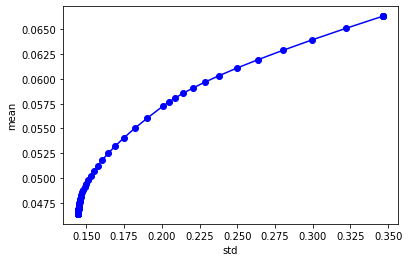

In [30]:
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'b-o')